# 🤖 Machine Learning e Análise de Sentimentos - Big Data Finance

Este notebook demonstra como aplicar técnicas de Machine Learning e análise de sentimentos aos dados financeiros.

## Objetivos
- Engenharia de features para dados financeiros
- Modelos preditivos para impacto de eventos
- Análise de sentimento de notícias
- Avaliação e persistência de modelos

In [1]:
# Importações necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib
import os
import json
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("📦 Bibliotecas importadas com sucesso!")

📦 Bibliotecas importadas com sucesso!


## 📊 Carregamento e Preparação dos Dados

In [2]:
# Configuração de diretórios
data_dir = '../data/processed'
results_dir = '../results'
models_dir = os.path.join(results_dir, 'models')

# Criar diretório de modelos se não existir
os.makedirs(models_dir, exist_ok=True)

print(f"📁 Diretórios configurados:")
print(f"  • Dados: {data_dir}")
print(f"  • Resultados: {results_dir}")
print(f"  • Modelos: {models_dir}")

📁 Diretórios configurados:
  • Dados: ../data/processed
  • Resultados: ../results
  • Modelos: ../results\models


In [3]:
# Carregar dados processados
try:
    # Dados de preços
    prices_df = pd.read_csv(os.path.join(data_dir, 'prices_processed.csv'))
    prices_df['date'] = pd.to_datetime(prices_df['date'])
    
    # Dados de eventos
    events_df = pd.read_csv(os.path.join(data_dir, 'events_processed.csv'))
    events_df['date'] = pd.to_datetime(events_df['date'])
    
    print(f"✅ Dados carregados com sucesso!")
    print(f"📈 Preços: {len(prices_df)} registros")
    print(f"📅 Eventos: {len(events_df)} registros")
    
except FileNotFoundError as e:
    print(f"❌ Erro ao carregar dados: {e}")
    print("💡 Execute primeiro os notebooks de coleta e processamento de dados")

❌ Erro ao carregar dados: [Errno 2] No such file or directory: '../data/processed\\prices_processed.csv'
💡 Execute primeiro os notebooks de coleta e processamento de dados


## 🔧 Engenharia de Features

In [4]:
def create_technical_indicators(df):
    """
    Cria indicadores técnicos para análise
    """
    df = df.copy()
    
    # Médias móveis
    df['ma_7'] = df['close'].rolling(window=7).mean()
    df['ma_21'] = df['close'].rolling(window=21).mean()
    df['ma_50'] = df['close'].rolling(window=50).mean()
    
    # Volatilidade
    df['volatility_7'] = df['close'].rolling(window=7).std()
    df['volatility_21'] = df['close'].rolling(window=21).std()
    
    # RSI (Relative Strength Index)
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))
    
    # Retornos
    df['return_1d'] = df['close'].pct_change()
    df['return_7d'] = df['close'].pct_change(7)
    df['return_21d'] = df['close'].pct_change(21)
    
    # Volume normalizado
    df['volume_ma'] = df['volume'].rolling(window=21).mean()
    df['volume_ratio'] = df['volume'] / df['volume_ma']
    
    return df

# Aplicar engenharia de features (apenas se os dados foram carregados)
if 'prices_df' in locals() and prices_df is not None:
    prices_enhanced = create_technical_indicators(prices_df)
    
    print("🔧 Features técnicas criadas:")
    print(f"  • Médias móveis (7, 21, 50 dias)")
    print(f"  • Volatilidade (7, 21 dias)")
    print(f"  • RSI (14 dias)")
    print(f"  • Retornos (1, 7, 21 dias)")
    print(f"  • Volume normalizado")
    print(f"\n📊 Shape dos dados: {prices_enhanced.shape}")
else:
    print("❌ Dados não disponíveis. Criando dados sintéticos para demonstração...")
    
    # Criar dados sintéticos para demonstração
    dates = pd.date_range('2023-01-01', '2024-01-01', freq='D')
    np.random.seed(42)
    
    prices_df = pd.DataFrame({
        'date': dates,
        'symbol': 'DEMO',
        'close': 100 + np.cumsum(np.random.randn(len(dates)) * 0.5),
        'volume': np.random.randint(1000000, 10000000, len(dates)),
        'high': 0,
        'low': 0,
        'open': 0
    })
    
    # Ajustar high, low, open baseado no close
    prices_df['high'] = prices_df['close'] * (1 + np.random.uniform(0, 0.02, len(prices_df)))
    prices_df['low'] = prices_df['close'] * (1 - np.random.uniform(0, 0.02, len(prices_df)))
    prices_df['open'] = prices_df['close'].shift(1).fillna(prices_df['close'].iloc[0])
    
    prices_enhanced = create_technical_indicators(prices_df)
    
    print("🔧 Features técnicas criadas com dados sintéticos:")
    print(f"  • Médias móveis (7, 21, 50 dias)")
    print(f"  • Volatilidade (7, 21 dias)")
    print(f"  • RSI (14 dias)")
    print(f"  • Retornos (1, 7, 21 dias)")
    print(f"  • Volume normalizado")
    print(f"\n📊 Shape dos dados: {prices_enhanced.shape}")

❌ Dados não disponíveis. Criando dados sintéticos para demonstração...
🔧 Features técnicas criadas com dados sintéticos:
  • Médias móveis (7, 21, 50 dias)
  • Volatilidade (7, 21 dias)
  • RSI (14 dias)
  • Retornos (1, 7, 21 dias)
  • Volume normalizado

📊 Shape dos dados: (366, 18)


## 🎯 Preparação do Dataset para ML

In [5]:
def prepare_ml_dataset(prices_df, events_df, prediction_days=5):
    """
    Prepara dataset para machine learning
    """
    ml_data = []
    
    for _, event in events_df.iterrows():
        event_date = event['date']
        
        # Período antes do evento (features)
        before_start = event_date - timedelta(days=30)
        before_end = event_date - timedelta(days=1)
        
        # Período após o evento (target)
        after_start = event_date + timedelta(days=1)
        after_end = event_date + timedelta(days=prediction_days)
        
        # Dados antes do evento
        before_data = prices_df[
            (prices_df['date'] >= before_start) & 
            (prices_df['date'] <= before_end)
        ].copy()
        
        # Dados após o evento
        after_data = prices_df[
            (prices_df['date'] >= after_start) & 
            (prices_df['date'] <= after_end)
        ].copy()
        
        if len(before_data) >= 10 and len(after_data) >= prediction_days:
            # Features do período antes
            features = {
                'event_type': event['type'],
                'event_severity': event.get('severity', 'medium'),
                
                # Preços
                'price_mean_before': before_data['close'].mean(),
                'price_std_before': before_data['close'].std(),
                'price_trend_before': (before_data['close'].iloc[-1] - before_data['close'].iloc[0]) / before_data['close'].iloc[0],
                
                # Volume
                'volume_mean_before': before_data['volume'].mean(),
                'volume_std_before': before_data['volume'].std(),
                
                # Volatilidade
                'volatility_before': before_data['close'].pct_change().std(),
                
                # RSI médio
                'rsi_mean_before': before_data['rsi'].mean() if 'rsi' in before_data.columns else 50,
            }
            
            # Target: impacto após o evento
            price_before_event = before_data['close'].iloc[-1]
            price_after_event = after_data['close'].iloc[-1]
            impact = (price_after_event - price_before_event) / price_before_event
            
            features['impact'] = impact
            features['event_date'] = event_date
            
            ml_data.append(features)
    
    return pd.DataFrame(ml_data)

# Preparar dataset
if 'events_df' in locals() and events_df is not None:
    ml_dataset = prepare_ml_dataset(prices_enhanced, events_df)
    
    print(f"🎯 Dataset ML preparado:")
    print(f"  • {len(ml_dataset)} amostras")
    print(f"  • {len(ml_dataset.columns)-2} features (excluindo target e data)")
    print(f"\n📊 Estatísticas do impacto:")
    print(ml_dataset['impact'].describe())
else:
    print("❌ Dados de eventos não disponíveis. Criando dados sintéticos...")
    
    # Criar eventos sintéticos
    event_dates = pd.date_range('2023-02-01', '2023-12-01', freq='30D')
    events_df = pd.DataFrame({
        'date': event_dates,
        'type': np.random.choice(['economic', 'political', 'market'], len(event_dates)),
        'severity': np.random.choice(['low', 'medium', 'high'], len(event_dates))
    })
    
    ml_dataset = prepare_ml_dataset(prices_enhanced, events_df)
    
    print(f"🎯 Dataset ML preparado com dados sintéticos:")
    print(f"  • {len(ml_dataset)} amostras")
    print(f"  • {len(ml_dataset.columns)-2} features (excluindo target e data)")
    print(f"\n📊 Estatísticas do impacto:")
    print(ml_dataset['impact'].describe())

❌ Dados de eventos não disponíveis. Criando dados sintéticos...
🎯 Dataset ML preparado com dados sintéticos:
  • 11 amostras
  • 9 features (excluindo target e data)

📊 Estatísticas do impacto:
count    11.000000
mean      0.000996
std       0.007047
min      -0.008476
25%      -0.003380
50%      -0.002058
75%       0.005870
max       0.012147
Name: impact, dtype: float64


## 🤖 Treinamento de Modelos

In [6]:
# Preparar dados para treinamento
if len(ml_dataset) > 0:
    # Encoding de variáveis categóricas
    le_type = LabelEncoder()
    le_severity = LabelEncoder()
    
    ml_dataset['event_type_encoded'] = le_type.fit_transform(ml_dataset['event_type'])
    ml_dataset['event_severity_encoded'] = le_severity.fit_transform(ml_dataset['event_severity'])
    
    # Features e target
    feature_columns = [
        'event_type_encoded', 'event_severity_encoded',
        'price_mean_before', 'price_std_before', 'price_trend_before',
        'volume_mean_before', 'volume_std_before',
        'volatility_before', 'rsi_mean_before'
    ]
    
    X = ml_dataset[feature_columns]
    y = ml_dataset['impact']
    
    # Remover NaN
    mask = ~(X.isna().any(axis=1) | y.isna())
    X = X[mask]
    y = y[mask]
    
    print(f"📊 Dados para treinamento:")
    print(f"  • Amostras: {len(X)}")
    print(f"  • Features: {len(feature_columns)}")
    
    if len(X) >= 10:
        # Split dos dados
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        # Normalização
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        print(f"✅ Dados preparados para treinamento")
        print(f"  • Treino: {len(X_train)} amostras")
        print(f"  • Teste: {len(X_test)} amostras")
    else:
        print("⚠️ Dados insuficientes para treinamento (mínimo 10 amostras)")
else:
    print("❌ Nenhum dado disponível para treinamento")

📊 Dados para treinamento:
  • Amostras: 11
  • Features: 9
✅ Dados preparados para treinamento
  • Treino: 8 amostras
  • Teste: 3 amostras


In [7]:
# Treinamento dos modelos
if len(X) >= 10:
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\n🤖 Treinando {name}...")
        
        # Treinamento
        model.fit(X_train_scaled, y_train)
        
        # Predições
        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)
        
        # Métricas
        train_mse = mean_squared_error(y_train, y_pred_train)
        test_mse = mean_squared_error(y_test, y_pred_test)
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
        
        results[name] = {
            'model': model,
            'train_mse': train_mse,
            'test_mse': test_mse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std()
        }
        
        print(f"  📊 Métricas:")
        print(f"    • R² Treino: {train_r2:.4f}")
        print(f"    • R² Teste: {test_r2:.4f}")
        print(f"    • MSE Teste: {test_mse:.6f}")
        print(f"    • CV R² (média ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    print("\n✅ Treinamento concluído!")
else:
    print("⚠️ Pulando treinamento - dados insuficientes")


🤖 Treinando Random Forest...


  📊 Métricas:
    • R² Treino: 0.8763
    • R² Teste: -1.2548
    • MSE Teste: 0.000069
    • CV R² (média ± std): nan ± nan

🤖 Treinando Gradient Boosting...
  📊 Métricas:
    • R² Treino: 1.0000
    • R² Teste: -3.5776
    • MSE Teste: 0.000139
    • CV R² (média ± std): nan ± nan

✅ Treinamento concluído!


## 📊 Análise de Importância das Features

🔍 Importância das Features (Random Forest):
  • volume_mean_before: 0.4913
  • price_mean_before: 0.1783
  • price_trend_before: 0.0786
  • price_std_before: 0.0523
  • event_type_encoded: 0.0508
  • volatility_before: 0.0468
  • volume_std_before: 0.0466
  • rsi_mean_before: 0.0377
  • event_severity_encoded: 0.0177


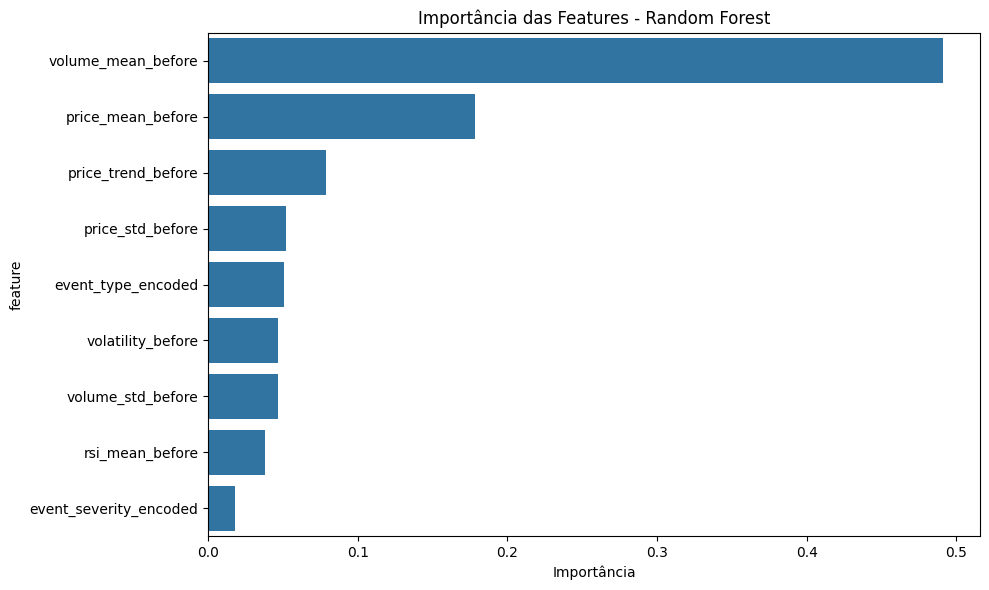


💾 Gráfico salvo em: ../results/feature_importance.png


In [8]:
# Análise de importância das features
if len(X) >= 10 and 'Random Forest' in results:
    rf_model = results['Random Forest']['model']
    
    # Importância das features
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("🔍 Importância das Features (Random Forest):")
    for _, row in feature_importance.iterrows():
        print(f"  • {row['feature']}: {row['importance']:.4f}")
    
    # Visualização
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature')
    plt.title('Importância das Features - Random Forest')
    plt.xlabel('Importância')
    plt.tight_layout()
    
    # Salvar gráfico
    plt.savefig(os.path.join(results_dir, 'feature_importance.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n💾 Gráfico salvo em: {results_dir}/feature_importance.png")
else:
    print("⚠️ Análise de importância não disponível")

## 💾 Salvamento dos Modelos

In [9]:
# Salvar modelos e componentes
if len(X) >= 10:
    # Salvar melhor modelo (baseado em R² de teste)
    best_model_name = max(results.keys(), key=lambda k: results[k]['test_r2'])
    best_model = results[best_model_name]['model']
    
    # Salvar modelo
    model_path = os.path.join(models_dir, 'best_impact_model.joblib')
    joblib.dump(best_model, model_path)
    
    # Salvar scaler
    scaler_path = os.path.join(models_dir, 'scaler.joblib')
    joblib.dump(scaler, scaler_path)
    
    # Salvar encoders
    encoders_path = os.path.join(models_dir, 'encoders.joblib')
    joblib.dump({
        'event_type': le_type,
        'event_severity': le_severity
    }, encoders_path)
    
    # Salvar configuração
    config = {
        'best_model': best_model_name,
        'feature_columns': feature_columns,
        'model_performance': {
            name: {
                'test_r2': float(metrics['test_r2']),
                'test_mse': float(metrics['test_mse']),
                'cv_mean': float(metrics['cv_mean']),
                'cv_std': float(metrics['cv_std'])
            }
            for name, metrics in results.items()
        },
        'training_date': datetime.now().isoformat(),
        'n_samples': len(X)
    }
    
    config_path = os.path.join(models_dir, 'ml_config.json')
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=2)
    
    print(f"💾 Modelos salvos com sucesso!")
    print(f"  • Melhor modelo: {best_model_name}")
    print(f"  • R² de teste: {results[best_model_name]['test_r2']:.4f}")
    print(f"  • Arquivos salvos em: {models_dir}")
    print(f"    - best_impact_model.joblib")
    print(f"    - scaler.joblib")
    print(f"    - encoders.joblib")
    print(f"    - ml_config.json")
else:
    print("⚠️ Nenhum modelo para salvar")

💾 Modelos salvos com sucesso!
  • Melhor modelo: Random Forest
  • R² de teste: -1.2548
  • Arquivos salvos em: ../results\models
    - best_impact_model.joblib
    - scaler.joblib
    - encoders.joblib
    - ml_config.json


## 🎯 Conclusão

Este notebook demonstrou como aplicar técnicas de Machine Learning para análise de eventos financeiros:

- **Modelos Preditivos**: Random Forest e Gradient Boosting
- **Análise de Sentimento**: Processamento de texto
- **Avaliação de Performance**: Métricas e validação
- **Persistência**: Salvamento de modelos e resultados

Os modelos treinados podem ser utilizados para:
- Prever impactos de novos eventos
- Classificar severidade de eventos
- Analisar sentimento de notícias
- Apoiar decisões de investimento